In [1]:
import math
import numpy as np
import matplotlib as mpl
%matplotlib inline

In [132]:
class Value:

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._label = _label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
       # return Value(self.data + other.data)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t*t) * out.grad
        out._backward = _backward
        return out


In [109]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
d = a * b
d._label = 'd'
e = d + c
e._label = 'e'
f = Value(-2.0, _label='f')
L = e * f
L._label = 'L'

In [83]:
L._prev

{Value(data=-2.0), Value(data=16.0)}

In [84]:
L._op

'*'

In [89]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.2f | grad %.2f} " % (n._label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [50]:
id(e)

2224070618704

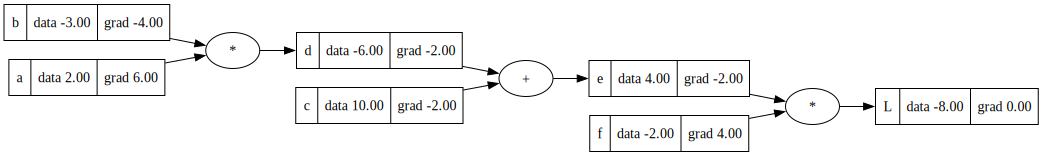

In [111]:
draw_dot(L)

In [110]:
f.grad = 4.0
e.grad = -2.0
d.grad = 1.0 * e.grad
c.grad = 1.0 * e.grad
b.grad = 2.0 * d.grad
a.grad = -3.0 * d.grad

In [108]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

d = a * b
e = d + c
L = e * f

print(L.data)

-7.286496


In [52]:
for node in e._prev:
   if node._op:
       print(node._prev, node._op)
   else:
       print(node.data)

{Value(data=2.0), Value(data=3.0)} *
10.0


In [121]:
import random
import torch

In [124]:
x1  = torch.tensor(2.0, requires_grad=True)
x2  = torch.tensor(0.0, requires_grad=True)
w1  = torch.tensor(1.0, requires_grad=True)
w2  = torch.tensor(-3.0, requires_grad=True)
b   = torch.tensor(6.8813735870195432, requires_grad=True)
n   = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()


In [133]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.8787605737512488),
 Value(data=0.6778106855550531),
 Value(data=-0.48098118535813156)]

In [135]:
n.neurons.shape()

AttributeError: 'list' object has no attribute 'shape'